In [1]:
import os
import time
from obspy import read, Stream, Trace
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
def generate_predictions(window, model, look_back, num_iterations=1000):
    # Normalise and  Reshape the initial window
    window = scale_data(window, scaler)
    window = np.reshape(window, (1, look_back, 1))
    

    # Pre-allocate the array to store all windows
    all_windows = np.zeros((num_iterations, look_back, 1))

    # Fill the first window
    all_windows[0] = window

    # Initialize the predictions list
    predictions = []

    # Loop to add predicted values
    for i in range(0, num_iterations-1):
        predicted_value = model.predict(all_windows[i:i+1])  # Example predicted value
        predictions.append(predicted_value[0])
        predicted_value = predicted_value.reshape(1, 1, 1)  # Ensure shape is (1, 1, 1)
        new_window = np.concatenate((all_windows[i:i+1], predicted_value), axis=1)
        all_windows[i+1] = new_window[:, -look_back:, :]  # Keep the last 100 elements

    predictions = inverse_scaler(predictions, scaler)
    return predictions

In [3]:
def get_data(st):
    """Take a stream, fill gap with interpolate  and return  data"""
    st =  st.merge(method=1, fill_value='interpolate')
    tr = st[0]
    data = tr.data.astype(np.float32).reshape(-1, 1)
    return data

In [4]:
def create_windowed_dataset(data, look_back=1, horizon=1, batch_size=32, shift=1):
    # Normalize the dataset
    dataset = data.reshape(-1, 1)
    dataset = scaler.transform(dataset)
    
    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    
    # Create windows
    dataset = dataset.window(look_back + horizon, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(look_back+ horizon))
    
    # Split into input and output
    dataset = dataset.map(lambda window: (window[:-horizon], window[-horizon:]))
    
    # batch the dataset
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [5]:

def fit_scaler(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = data.reshape(-1, 1)
    scaler.fit(data)
    return scaler

def scale_data(data, scaler):
    scaled_data = scaler.transform(data)
    return scaled_data

def inverse_scaler(scaled_data, scaler):
    restored_data = scaler.inverse_transform(scaled_data)
    return restored_data

In [6]:
#Full Year
st = read("Data/MX_MOIG_BHZ_2023-01-01_2024-01-01.mseed")

In [7]:
data = get_data(st)

In [8]:
scaler = fit_scaler(data)

In [9]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [14]:
look_back = 6000
batch_size = 64
shift = 1
horizon = 1000

In [15]:
train_dataset = create_windowed_dataset(
    train_data, look_back, horizon, batch_size, shift
)
validation_dataset = create_windowed_dataset(
    test_data, look_back, horizon, batch_size, shift
)

In [17]:
max_steps = (len(train_data)//(look_back*batch_size))-1
max_steps

1313

In [21]:
#Create and fit LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))  # Experiment with units
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(horizon))
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

# Define the filepath where you want to save the model checkpoints
checkpoint_path = "my_model_checkpoints/model_2023_i6000_o1000_{epoch:02d}.hdf5"

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Save the entire model, not just weights
    save_freq="epoch",
    )

#num_windows = (len(train_data) - look_back + 1) // shift
steps_per_epoch = 1000
validation_steps= 5


# Train the model using the generator
model.fit(train_dataset,
    epochs=100,
    callbacks=[checkpoint_callback],
    verbose= 1,
    steps_per_epoch = steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
          )

Epoch 1/100
1000/1000 [==============================] - 870s 866ms/step - loss: 10.9096 - val_loss: 0.8462
Epoch 2/100
1000/1000 [==============================] - 856s 856ms/step - loss: 0.3329 - val_loss: 0.1262
Epoch 3/100
1000/1000 [==============================] - 850s 850ms/step - loss: 0.2147 - val_loss: 0.3096
Epoch 4/100
1000/1000 [==============================] - 853s 853ms/step - loss: 0.2204 - val_loss: 0.1764
Epoch 5/100
1000/1000 [==============================] - 847s 847ms/step - loss: 0.1844 - val_loss: 0.0314
Epoch 6/100
1000/1000 [==============================] - 891s 891ms/step - loss: 0.1877 - val_loss: 0.1724
Epoch 7/100
1000/1000 [==============================] - 864s 864ms/step - loss: 0.1638 - val_loss: 0.1504
Epoch 8/100
1000/1000 [==============================] - 870s 870ms/step - loss: 0.1478 - val_loss: 0.1686
Epoch 9/100
1000/1000 [==============================] - 900s 901ms/step - loss: 0.1588 - val_loss: 0.1584
Epoch 10/100
1000/1000 [============

KeyboardInterrupt: 

In [ ]:

#model = load_model('my_model_checkpoints/model_AP_MAY_72.hdf5')

In [ ]:
#look_back = 12000
#test_predictions = generate_predictions(scaled_window, model, look_back, num_iterations=100)
#test_predictions

In [22]:
loss = model.evaluate(test_dataset, steps=validation_steps, verbose=1)

print(f'Test Loss: {loss}')

5/5 [==============================] - 2s 307ms/step - loss: 0.0845
Test Loss: 0.08450715988874435


In [23]:
# Evaluate the model on the test dataset
loss, mse = model.evaluate(test_dataset, steps=validation_steps, verbose=1)

print(f'Test Loss (MAPE): {loss}')
print(f'Test MSE: {mse}')

5/5 [==============================] - 2s 387ms/step - loss: 0.0845


TypeError: cannot unpack non-iterable float object

look_back = 12000
horizon = 20
predictions = []
window = test_data[0:12000]
scaled_window = scale_data(window, scaler)
# Ensure scaled_window is correctly shaped
new_window = scaled_window.reshape(1, look_back, 1)
window = test_data[0:12000]

for i in range(horizon):
    # Predict the next value
    predicted_value = model.predict(new_window, verbose=1)
    predictions.append(predicted_value[0])
    
    # Update the window with the new prediction
    new_window = np.roll(new_window, -1, axis=1)
    new_window[0, -1, 0] = predicted_value

# Convert predictions to a numpy array for further processing
predictions = inverse_scaler(np.array(predictions), scaler)
print(predictions)

In [28]:
validation = test_dataset.take(10)

In [29]:

validation_pred = model.predict(validation, verbose = 1)

10/10 [==============================] - 11s 926ms/step


In [30]:
len(validation_pred)

640

In [35]:
validation_pred[0]

array([0.501461  , 0.50077707, 0.50075084, 0.50103045, 0.5010132 ,
       0.501709  , 0.5010698 , 0.5002271 , 0.50132614, 0.5004081 ,
       0.50070417, 0.4990963 , 0.50067997, 0.50131047, 0.50183547,
       0.5025434 , 0.5005528 , 0.5003466 , 0.5014696 , 0.5012854 ,
       0.50144637, 0.5014615 , 0.5001281 , 0.5015534 , 0.50203156,
       0.5014148 , 0.5017843 , 0.50091773, 0.50199634, 0.5013157 ,
       0.50166756, 0.5008272 , 0.50092924, 0.49982905, 0.5013751 ,
       0.50108385, 0.50121903, 0.5005226 , 0.5012405 , 0.5012057 ,
       0.5019589 , 0.5017139 , 0.5012597 , 0.50091517, 0.5010947 ,
       0.50186056, 0.50183284, 0.5022435 , 0.5012751 , 0.5001156 ,
       0.5004092 , 0.5004655 , 0.50079036, 0.5004543 , 0.501376  ,
       0.5005864 , 0.50046474, 0.500845  , 0.50040275, 0.50046104,
       0.5001175 , 0.5011276 , 0.5017108 , 0.50067806, 0.5016979 ,
       0.5005908 , 0.50145113, 0.5018632 , 0.50094914, 0.5014266 ,
       0.5014423 , 0.50083697, 0.5018164 , 0.50139403, 0.50080

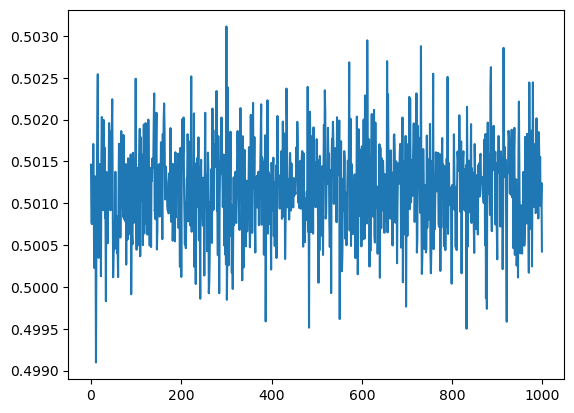

In [36]:
plt.plot(validation_pred[0])

In [51]:
testing2 = train_data[6000:12000]
testing2 = np.reshape(testing, (1, len(testing2), 1))
validation_pred2 = model.predict(testing, verbose = 1)

1/1 [==============================] - 0s 277ms/step


In [54]:
test = validation_pred2 -validation_pred
test

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

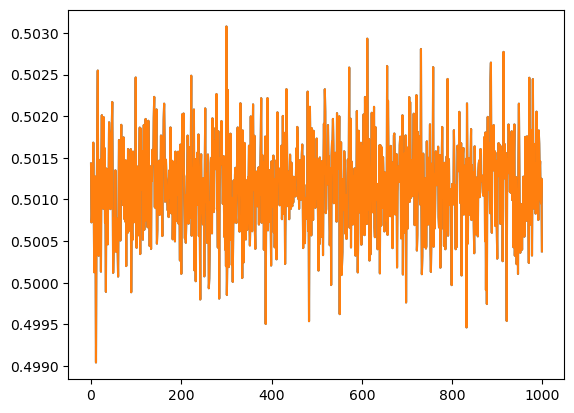

In [53]:
plt.plot(validation_pred[0])
plt.plot(validation_pred2[0])